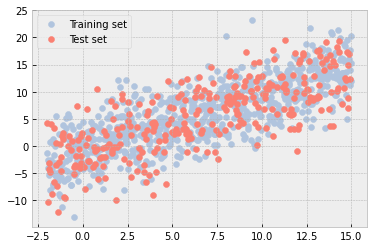

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import normal
plt.style.use('bmh')
%matplotlib inline

np.random.seed(3)

x = np.linspace(start = -2, stop=15, num=1000)
intercept, x_coef = -1, 1 
y = [x_coef*i + intercept for i in x]
y = [i+normal(0, 4) for i in y]

data = pd.DataFrame({'x': x, 'y': y})

# Split the data into training/testing sets
train, test = train_test_split(data, test_size=0.3)
X_train, X_test = train.x, test.x

# Split the targets into training/testing sets
y_train, y_test = train.y, test.y

plt.scatter(X_train, y_train, color='lightsteelblue', label = 'Training set')
plt.scatter(X_test, y_test, color='salmon', label = 'Test set')
plt.legend()

In [2]:
import mxnet as mx
from mxnet import np,gluon

batch_size=64
X_train_tensor=X_train.values.astype('float32')[:,np.newaxis]
y_train_tensor=y_train.values.astype('float32')[:,np.newaxis]
train_ds=mx.gluon.data.dataset.ArrayDataset(X_train_tensor,y_train_tensor)
train_loader=gluon.data.dataloader.DataLoader(train_ds,batch_size=batch_size,shuffle=True)

X_test_tensor=X_test.values.astype('float32')[:,np.newaxis]
y_test_tensor=y_test.values.astype('float32')[:,np.newaxis]
test_ds=mx.gluon.data.dataset.ArrayDataset(X_test_tensor,y_test_tensor)
test_loader=gluon.data.dataloader.DataLoader(test_ds,batch_size=batch_size,shuffle=False)

In [4]:
import sys
sys.path.append("../") 

In [5]:
len(train_loader)*batch_size

704

In [6]:
X_train.shape

(700,)

# No Uncertainty

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon,np
from hamiltonian.inference.bbb import sgd
from hamiltonian.models.linear import linear

model_ctx=mx.cpu()
hyper={'alpha':np.array(10.0, ctx=model_ctx),'scale':1.}
model=linear(hyper,in_units=1,out_units=1,ctx=model_ctx)
inference=sgd(model,step_size=0.0005,ctx=model_ctx)

In [7]:
train_sgd=True
num_epochs=1000
if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,
                           data_loader=train_loader,chain_name='linear_map.h5',verbose=True)

iteration 0, train loss: 1170.1803, train accuracy : 0.0871
iteration 100, train loss: 496.7298, train accuracy : 0.1216
iteration 200, train loss: 543.2988, train accuracy : 0.1222
iteration 300, train loss: 572.4665, train accuracy : 0.1216
iteration 400, train loss: 347.5391, train accuracy : 0.1206
iteration 500, train loss: 487.7392, train accuracy : 0.1195
iteration 600, train loss: 578.6428, train accuracy : 0.1185
iteration 700, train loss: 642.4195, train accuracy : 0.1178
iteration 800, train loss: 524.0192, train accuracy : 0.1172
iteration 900, train loss: 623.7101, train accuracy : 0.1168


In [8]:

[par.data() for par in  model.net.collect_params().values()]

[array([[1.0008366]]), array([-0.8046753])]

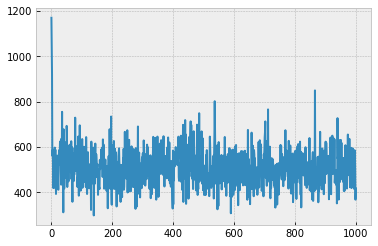

In [9]:
plt.plot(loss)

In [10]:
params={var:theta.data() for var,theta in  zip(par,par.values())}

In [11]:
total_samples,total_labels,total_loglike=inference.predict(params,num_samples=100,data_loader=test_loader)

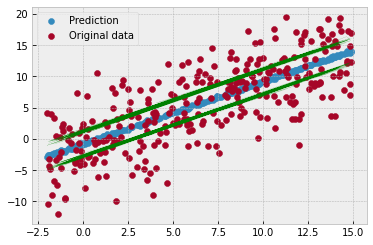

In [13]:
plt.scatter(X_test_tensor, total_samples.mean(axis=0), label = 'Prediction')
plt.plot(X_test,total_samples.mean(axis=0)+2*total_samples.std(axis=0),'g',linewidth=0.1)
plt.plot(X_test,total_samples.mean(axis=0)-2*total_samples.std(axis=0),'g',linewidth=0.1)
plt.scatter(X_test, y_test, label = 'Original data')
plt.legend()

# Aleatoric Uncertainty

In [12]:
import mxnet as mx
from mxnet import nd, autograd, gluon,np
from hamiltonian.inference.bbb import sgd
from hamiltonian.models.linear import linear_aleatoric

model_ctx=mx.cpu()
hyper={'alpha':np.array(10.0, ctx=model_ctx)}
model=linear_aleatoric(hyper,in_units=1,out_units=1,ctx=model_ctx)
inference=sgd(model,step_size=0.0005,ctx=model_ctx)

In [13]:
train_sgd=True
num_epochs=1000
if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,
                           data_loader=train_loader,chain_name='linear_aleatoric_map.h5',verbose=True)

iteration 0, train loss: 1464.8429, train accuracy : 0.0914
iteration 100, train loss: 710.3469, train accuracy : 0.1212
iteration 200, train loss: 434.1826, train accuracy : 0.1203
iteration 300, train loss: 495.3813, train accuracy : 0.1188
iteration 400, train loss: 372.4373, train accuracy : 0.1177
iteration 500, train loss: 482.6359, train accuracy : 0.1171
iteration 600, train loss: 302.1871, train accuracy : 0.1167
iteration 700, train loss: 276.0917, train accuracy : 0.1166
iteration 800, train loss: 434.3890, train accuracy : 0.1162
iteration 900, train loss: 319.1600, train accuracy : 0.1158


In [14]:
params={var:theta.data() for var,theta in  zip(par,par.values())}
total_samples,total_labels,total_loglike=inference.predict(params,num_samples=100,data_loader=test_loader)

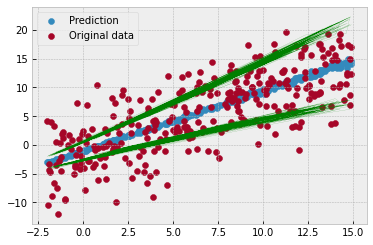

In [15]:
plt.scatter(X_test_tensor, total_samples.mean(axis=0), label = 'Prediction')
plt.plot(X_test_tensor,total_samples.mean(axis=0)+2*total_samples.std(axis=0),'g',linewidth=0.1)
plt.plot(X_test_tensor,total_samples.mean(axis=0)-2*total_samples.std(axis=0),'g',linewidth=0.1)
plt.scatter(X_test, y_test, label = 'Original data')
plt.legend()

In [11]:
params

{'0.weight': array([[1.047699],
        [4.611945]]),
 '0.bias': array([-1.0317962,  2.1644974])}